In [ ]:
#| default_exp layers

# Monotonic dense layer

> Monotonic dense layer is a learnable layer built on top of `tf.keras.layers.Dense` layer, but monotonic w.r.t. inputs.

In [ ]:
#| export

from typing import *
from contextlib import contextmanager

import numpy as np
from numpy.typing import ArrayLike, NDArray

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
import matplotlib.pyplot as plt

import pandas as pd

from tensorflow.keras import Model
from tensorflow.keras.layers import Input

## Monotonic Dense Unit Class 

In [ ]:
# |export


def get_saturated_activation(
    convex_activation: Callable[[Any], Any],
    concave_activation: Callable[[Any], Any],
    a: float = 1.0,
    c: float = 1.0,
):
    def saturated_activation(
        x,
        convex_activation: Callable[[Any], Any]=convex_activation,
        concave_activation: Callable[[Any], Any]=concave_activation,
        a: float=a,
        c: float=c,
    ):
        cc = convex_activation(tf.ones_like(x) * c)
        return a * tf.where(
            x <= c,
            convex_activation(x + c) - cc,
            concave_activation(x - c) + cc,
        )
    
    return saturated_activation

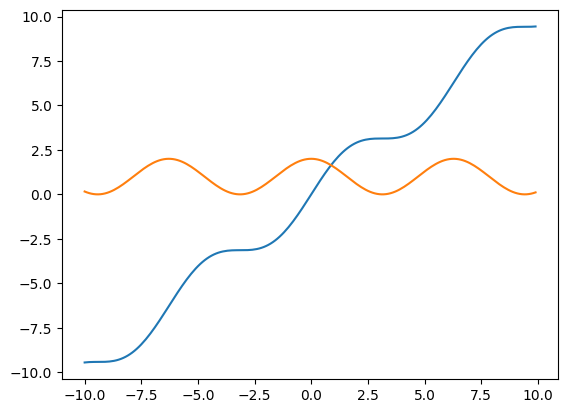

In [ ]:
# this function is problematic for unsaturated activations only

x = np.arange(-10, 10, 0.1)
y = np.sin(x) + x
dy = np.cos(x) + 1
plt.plot(x, y)
plt.plot(x, dy)
# plt.legend()
plt.show()

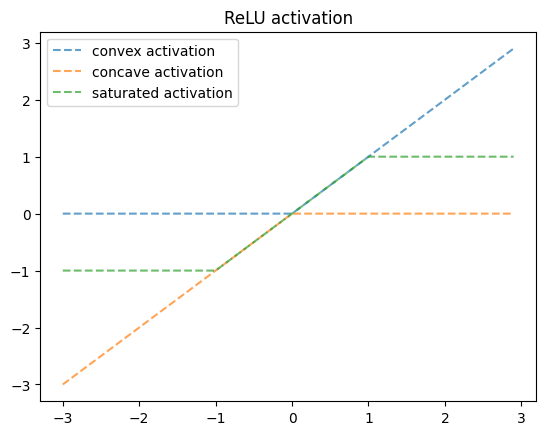

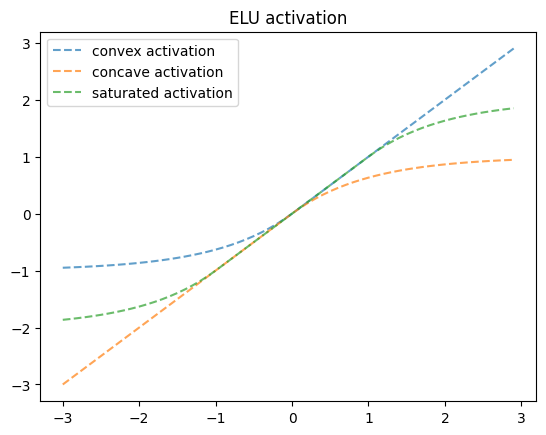

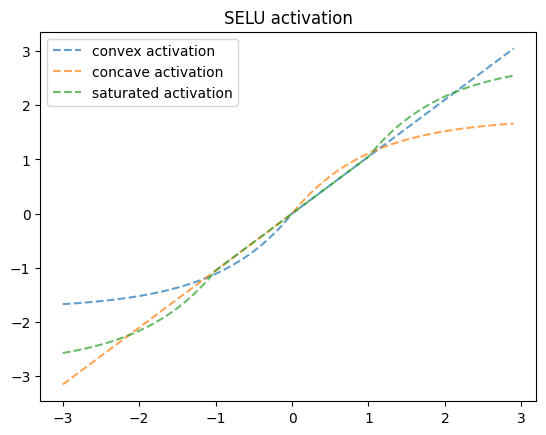

In [ ]:
for name in ["ReLU", "ELU", "SELU"]:
    convex_activation = tf.keras.activations.get(name.lower())
    concave_activation = lambda x: -convex_activation(-x)
    saturated_activation = get_saturated_activation(convex_activation, concave_activation)

    x = np.arange(-3, 3, 0.1)
    plt.plot(x, convex_activation(x), label="convex activation", linestyle="--", alpha=0.7)
    plt.plot(x, concave_activation(x), label="concave activation", linestyle="--", alpha=0.7)
    plt.plot(x, saturated_activation(x), label="saturated activation", linestyle="--", alpha=0.7)
    plt.legend()
    plt.title(f"{name} activation")
    plt.show()

In [ ]:
# | export


class MonotonicDense(Dense):
    """Monotonic counterpart of the regular Dense Layer of tf.Keras"""

    def __init__(
        self,
        units: int,
        *,
        activation: Optional[Union[str, Callable]] = None,
        monotonicity_indicator: Union[int, NDArray[np.int_], List[int]] = 1,
        is_convex: bool = False,
        is_concave: bool = False,
        activation_weights: Tuple[float, float, float] = (1.0, 1.0, 1.0),
        **kwargs,
    ):
        """Constructs a new MonotonicDense instance.

        Args:
            units: Positive integer, dimensionality of the output space.
            activation: Activation function to use, it is assumed to be convex monotonically
                increasing function such as "relu" or "elu"
            monotonicity_indicator: Vector to indicate which of the inputs are monotonically increasing or
                monotonically decreasing or non-monotonic. Has value 1 for monotonically increasing,
                -1 for monotonically decreasing and 0 for non-monotonic.
            is_convex: convex if set to True
            is_concave: concave if set to True
            activation_weights: relative weights for each type of activation, the default is (1.0, 1.0, 1.0).
                Ignored if is_convex or is_concave is set to True
            **kwargs: passed directly to the constructor of `Dense`

        Returns:
            N-D tensor with shape: `(batch_size, ..., units)`.

        Raise:
            ValueError:
                - if both **is_concave** and **is_convex** are set to **True**, or
                - if any component of activation_weights is negative
        """
        super(MonotonicDense, self).__init__(units, activation=None, **kwargs)

        if activation:
            self.convex_activation = tf.keras.activations.get(activation)
            self.concave_activation: Optional[
                Callable[[Any], Any]
            ] = lambda x: -self.convex_activation(-x)
            self.saturated_activation: Optional[
                Callable[[Any], Any]
            ] = get_saturated_activation(
                self.convex_activation, self.concave_activation
            )
        else:
            self.convex_activation = None
            self.concave_activation = None
            self.saturated_activation = None

        # if monotonicity_indicator is int, we need to convert it to an array of length units
        if isinstance(monotonicity_indicator, int):
            self.monotonicity_indicator: Union[
                int, NDArray[np.int_]
            ] = monotonicity_indicator
        else:
            self.monotonicity_indicator = np.array(
                monotonicity_indicator, dtype="int32"
            ).reshape(-1, 1)

        if is_convex and is_concave:
            raise ValueError(
                "The model cannot be set to be both convex and concave (only linear functions are both)."
            )

        self.is_convex = is_convex
        self.is_concave = is_concave

        if len(activation_weights) != 3:
            raise ValueError(f"{activation_weights=}, {sum(activation_weights)=}")
        if (np.array(activation_weights) < 0).any():
            raise ValueError(f"{activation_weights=}, {sum(activation_weights)=}")
        self.activation_weights = np.array(activation_weights) / sum(activation_weights)

    @contextmanager
    def replace_kernel(self):
        """Replaces kernel with non-negative or non-positive values according
        to the **monotonicity_indicator**
        """
        kernel_org = self.kernel

        abs_kernel = tf.abs(self.kernel)
        if isinstance(self.monotonicity_indicator, int):
            if self.monotonicity_indicator == 1:
                self.kernel = abs_kernel
            elif self.monotonicity_indicator == -1:
                self.kernel = -abs_kernel
        else:
            self.kernel = tf.where(
                self.monotonicity_indicator == 1,
                abs_kernel,
                self.kernel,
            )
            self.kernel = tf.where(
                self.monotonicity_indicator == -1, -abs_kernel, self.kernel
            )
        yield

        self.kernel = kernel_org

    def build(self, input_shape, *args, **kwargs):
        """Build

        Args:
            input_shape: input tensor
        """
        super(MonotonicDense, self).build(input_shape, *args, **kwargs)
        if not isinstance(self.monotonicity_indicator, int):
#             if input_shape[]
            pass
#         raise RuntimeError
        
        

    def call(self, inputs):
        """Call

        Args:
            inputs: input tensor
        """
        # calculate W'*x+y after we replace the kernal according to monotonicity vector
        with self.replace_kernel():
            y = super(MonotonicDense, self).call(inputs)

        # apply activation function according to convex/concave flags
        if self.convex_activation is not None:
            if self.is_convex:
                y = self.convex_activation(y)
            elif self.is_concave:
                y = self.concave_activation(y)
            else:
                convex_len = round(self.activation_weights[0] * self.units)
                concave_len = round(self.activation_weights[1] * self.units)
                saturated_len = self.units - convex_len - concave_len

                # use all three activation functions
                y_convex = self.convex_activation(y[:, :convex_len])
                y_concave = self.concave_activation(
                    y[:, convex_len : convex_len + concave_len]
                )
                y_saturated = self.saturated_activation(
                    y[
                        :,
                        convex_len
                        + concave_len : convex_len
                        + concave_len
                        + saturated_len,
                    ]
                )

                y = K.concatenate([y_convex, y_concave, y_saturated])

        return y

In [ ]:
def print_header(header: str, length: int=120):
    n = (length-2-len(header)) // 2
    print("*"*length)
    print("*" + " "*(length-2) + "*")
    print("*" + " "*n + header + " "*(length-n-2-len(header)) + "*")
    print("*" + " "*(length-2) + "*")
    print("*"*length)
    print()
print_header("hello")

************************************************************************************************************************
*                                                                                                                      *
*                                                        hello                                                         *
*                                                                                                                      *
************************************************************************************************************************



In [ ]:
m, n = 101, 103

for monotonicity_indicator in [-1, 0, 1]:
    print_header(f"{monotonicity_indicator=}")
    tf.keras.utils.set_random_seed(42)
    layer = MonotonicDense(m, monotonicity_indicator=monotonicity_indicator)
    layer.build(input_shape=(n, ))
    with layer.replace_kernel():
        kernel = layer.kernel
    assert kernel.shape == (n, m)
    if monotonicity_indicator == 1:
        assert (kernel.numpy() >= 0).all()
    elif monotonicity_indicator == -1:
        assert (kernel.numpy() <= 0).all()
    elif monotonicity_indicator == 0:
        assert (kernel.numpy() <= 0).any()
        assert (kernel.numpy() >= 0).any()


************************************************************************************************************************
*                                                                                                                      *
*                                              monotonicity_indicator=-1                                               *
*                                                                                                                      *
************************************************************************************************************************

************************************************************************************************************************
*                                                                                                                      *
*                                               monotonicity_indicator=0                                               *
*                              

In [ ]:
monotonicity_indicator = np.array([1, 0, -1])

layer = MonotonicDense(101, monotonicity_indicator=monotonicity_indicator)

layer.build(input_shape=(4, ))


In [ ]:
tf.keras.utils.set_random_seed(42)

for x in [np.ones((5, 7)), np.zeros((2, 3))]:
    for activation in [None, "elu", "relu"]:
        print_header(f"{x.shape=}, {activation=}")
        for is_convex in [True, False]:
            for is_concave in [True, False]:
                if is_concave and is_convex:
                    continue
                print_header(f"{x.shape=}, {is_convex=}, {is_concave=}")

                layer = MonotonicDense(
                    units=10,
                    is_convex=is_convex,
                    is_concave=is_concave,
                    activation="relu",
                )
                y = layer(x)
            print(f"{y=}")

In [ ]:
tf.keras.utils.set_random_seed(42)

for x in [np.ones((5, 7)), np.zeros((2, 3))]:
    for activation in [None, "elu", "relu"]:
        print_header(f"{x.shape=}, {activation=}")
        for is_convex in [True, False]:
            for is_concave in [True, False]:
                if is_concave and is_convex:
                    continue
                print_header(f"{x.shape=}, {is_convex=}, {is_concave=}")

        monotonicity_indicator = np.array([1, 1, -1, -1, 0, 0, 0])

        layer = MonotonicDense(
            units=8,
            activation="relu",
            monotonicity_indicator=monotonicity_indicator,
            is_convex=is_convex,
            is_concave=is_concave,
        )

        y = layer(np.ones((6, 7))).numpy()

        print(f"{y.shape=}")
        print(f"{layer.kernel.shape=}")

        assert y.shape == (6, 8)

## Universal approximation

In [ ]:
def generate_heavyside_dataset(n_points=100_000):
    tf.keras.utils.set_random_seed(42)

    rng = np.random.default_rng(42)
    x_train = rng.normal(size=n_points)
    y_train = (x_train >= 0).astype("float")
    df_train = pd.DataFrame(dict(x=x_train, y=y_train))

    return df_train